## Generador de Prediccion Estandar

In [196]:
#Se limpia la memoria
rm(list=ls())
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,806812,43.1,2717718,145.2,2717718,145.2
Vcells,1566057,12.0,209935052,1601.7,284568756,2171.1


In [197]:
semilla <- 100019
set.seed(semilla)

In [198]:
#cargo las librerias que necesito
require("data.table")
require("rpart")
require("rpart.plot")
#Contiene funciones para evaluar performance de la clasificación
library("ROCR")

In [199]:
setwd("C:/_MCD/Labo1/code")  #Establezco el Working Directory

In [200]:
dataset  <- fread("./datasets/competencia1_2022_FE_monotonas.csv")

In [201]:
dtrain  <- dataset[ foto_mes==202101 ]  #defino donde voy a entrenar
dapply  <- dataset[ foto_mes==202103 ]  #defino donde voy a aplicar el modelo

In [202]:
modelo  <- rpart(formula=    "clase_ternaria ~ .", #quiero predecir clase_ternaria a partir de el resto de las variables
                 data =      dtrain,  #los datos donde voy a entrenar
                 xval=       0,
                 cp=        -0.483, #esto significa no limitar la complejidad de los splits
                 minsplit= 531,   #minima cantidad de registros para que se haga el split
                 minbucket=  21,   #tamaño minimo de una hoja
                 maxdepth=  7 )  #PRUEBO  una profundidad de 10

Ahora grafico el arbol, va a ser muy frondoso porque la profundidad es de 10

In [203]:
#prp(modelo, extra=101, digits=5, branch=1, type=4, varlen=0, faclen=0)

Ahora aplico al modelo  a los datos muevos  y genero la salida para kaggle

aplico el modelo a los datos nuevos

In [204]:
prediccion  <- predict( modelo, dapply , type = "prob") #aplico el modelo

prediccion es una matriz con TRES columnas, llamadas "BAJA+1", "BAJA+2"  y "CONTINUA"
cada columna es el vector de probabilidades 

agrego a dapply una columna nueva que es la probabilidad de BAJA+2

In [205]:
dapply[ , prob_baja2 := prediccion[, "BAJA+2"] ]

solo le envio estimulo a los registros con probabilidad de BAJA+2 mayor  a  1/40

In [206]:
head(dapply)

numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,⋯,sqrt_matm,sqrt_catm_trx_other,sqrt_matm_other,sqrt_Visa_mfinanciacion_limite,sqrt_Visa_Fvencimiento,sqrt_Visa_Finiciomora,sqrt_Visa_msaldototal,sqrt_Visa_mlimitecompra,sqrt_Master_mlimitecompra,prob_baja2
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
31115668,202103,1,0,0,56,134,688.41,26701.84,98.82,⋯,184.43698,1.414214,108.30512,251.6784,46.465041,NA,117.6923,265.2923,265.2923,0.0003654255
31115678,202103,1,0,0,48,102,78.43,24418.75,-73.62,⋯,54.15256,1.732051,64.07418,NA,NA,NA,NA,NA,NA,0.0007902015
31117415,202103,1,0,0,60,55,8101.55,3162.23,13399.50,⋯,132.64615,1.000000,68.49818,251.6784,40.914545,NA,168.5846,265.2923,265.2923,0.0039325352
31117711,202103,1,0,0,46,275,14825.78,138050.05,1146.27,⋯,0.00000,0.000000,0.00000,721.6077,9.486833,NA,118.3093,760.6965,760.6965,0.0003654255
31118145,202103,1,0,0,47,194,2015.61,31240.49,1791.25,⋯,0.00000,0.000000,0.00000,251.6784,42.355637,NA,33.6000,265.2923,290.6131,0.0030872138
31118204,202103,1,0,0,68,260,14424.33,71750.45,3694.07,⋯,0.00000,0.000000,0.00000,595.5797,11.000000,NA,210.1990,627.7961,NA,0.0039325352


In [207]:
nrow(dapply)

[1] 162900

In [208]:
dapply[ , Predicted  := as.numeric(prob_baja2 > 1/40) ]

In [209]:
fwrite( dapply[,list(numero_de_cliente, Predicted)],
        file= "normal.csv", 
        sep= "," )

creo la carpeta donde va el experimento

In [210]:
#dir.create( "./exp/competencia1" ) 

Hago lo mismo con train para evaluar en entrenamiento

In [211]:
prediccion  <- predict( modelo, dtrain , type = "prob") #aplico el modelo
dtrain[ , prob_baja2 := prediccion[, "BAJA+2"] ]
dtrain[ , Predicted  := as.numeric(prob_baja2 > 1/40) ]

### Curva ROC

In [212]:
dtrain[, clase := 0]
dtrain[ clase_ternaria=='BAJA+2' ,   clase:= 1]

In [213]:
#Calculo las metricas
pred <- prediction(dtrain$Predicted, dtrain$clase)

#Calculo las metricas
perf <- performance(pred, measure = "tpr", x.measure = "fpr")

#Grafico la ROC
#plot(perf, col=rainbow(10))

#Determino AUC
#performance( pred,"auc")@y.values

### Ganancia

In [214]:
#Ganancia por TP
kTPGain               <-  78000

#Pérdida por FP
kFPGain               <-  -2000

#Calculo la ganancia
dtrain[  , ganancia:= kFPGain ] #-1250
dtrain[ clase_ternaria=='BAJA+2' ,   ganancia:= kTPGain] #48750
sum( dtrain$ganancia )

gan <- sum( dtrain[ dtrain$Predicted==1, ganancia] )

#TP
truepositive <- sum(dtrain$Predicted*dtrain[,clase])

#Incentivados Totales
incentivados <- sum(dtrain$Predicted)

print(paste("La Ganancia es:", gan))
print(paste("TP:", truepositive))
print(paste("Incentivados:",incentivados))

[1] -254684000

[1] "La Ganancia es: 27088000"
[1] "TP: 532"
[1] "Incentivados: 7736"


grabo el dataset

In [215]:
nombre_archivo_salida <- "./exp/competencia1/inicial.csv"

In [216]:
fwrite( dapply[ , list(numero_de_cliente, Predicted) ], #solo los campos para Kaggle
        file= nombre_archivo_salida, 
        sep= "," )

In [217]:
options(scipen=999)

In [218]:
modelo

n= 161342 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

  1) root 161342 1514 CONTINUA (0.0041154814 0.0052683120 0.9906162066)  
    2) ctrx_quarter< 13.5 8400  711 CONTINUA (0.0347619048 0.0498809524 0.9153571429)  
      4) mcuentas_saldo< -1256.1 2928  416 CONTINUA (0.0618169399 0.0802595628 0.8579234973)  
        8) cprestamos_personales< 1.5 2328  396 CONTINUA (0.0743127148 0.0957903780 0.8298969072)  
         16) cdescubierto_preacordado< 0.5 321  116 CONTINUA (0.1713395639 0.1900311526 0.6386292835) *
         17) cdescubierto_preacordado>=0.5 2007  280 CONTINUA (0.0587942202 0.0807174888 0.8604882910)  
           34) mpasivos_margen< 8.05 1339  221 CONTINUA (0.0634802091 0.1015683346 0.8349514563)  
             68) Visa_fechaalta>=720.5 867  177 CONTINUA (0.0807381776 0.1234140715 0.7958477509)  
              136) log_mrentabilidad>=7.018767 700  160 CONTINUA (0.0928571429 0.1357142857 0.7714285714) *
              137) log_mrentabilidad< 7.018767 

Warning message:
"labs do not fit even at cex 0.15, there may be some overplotting"


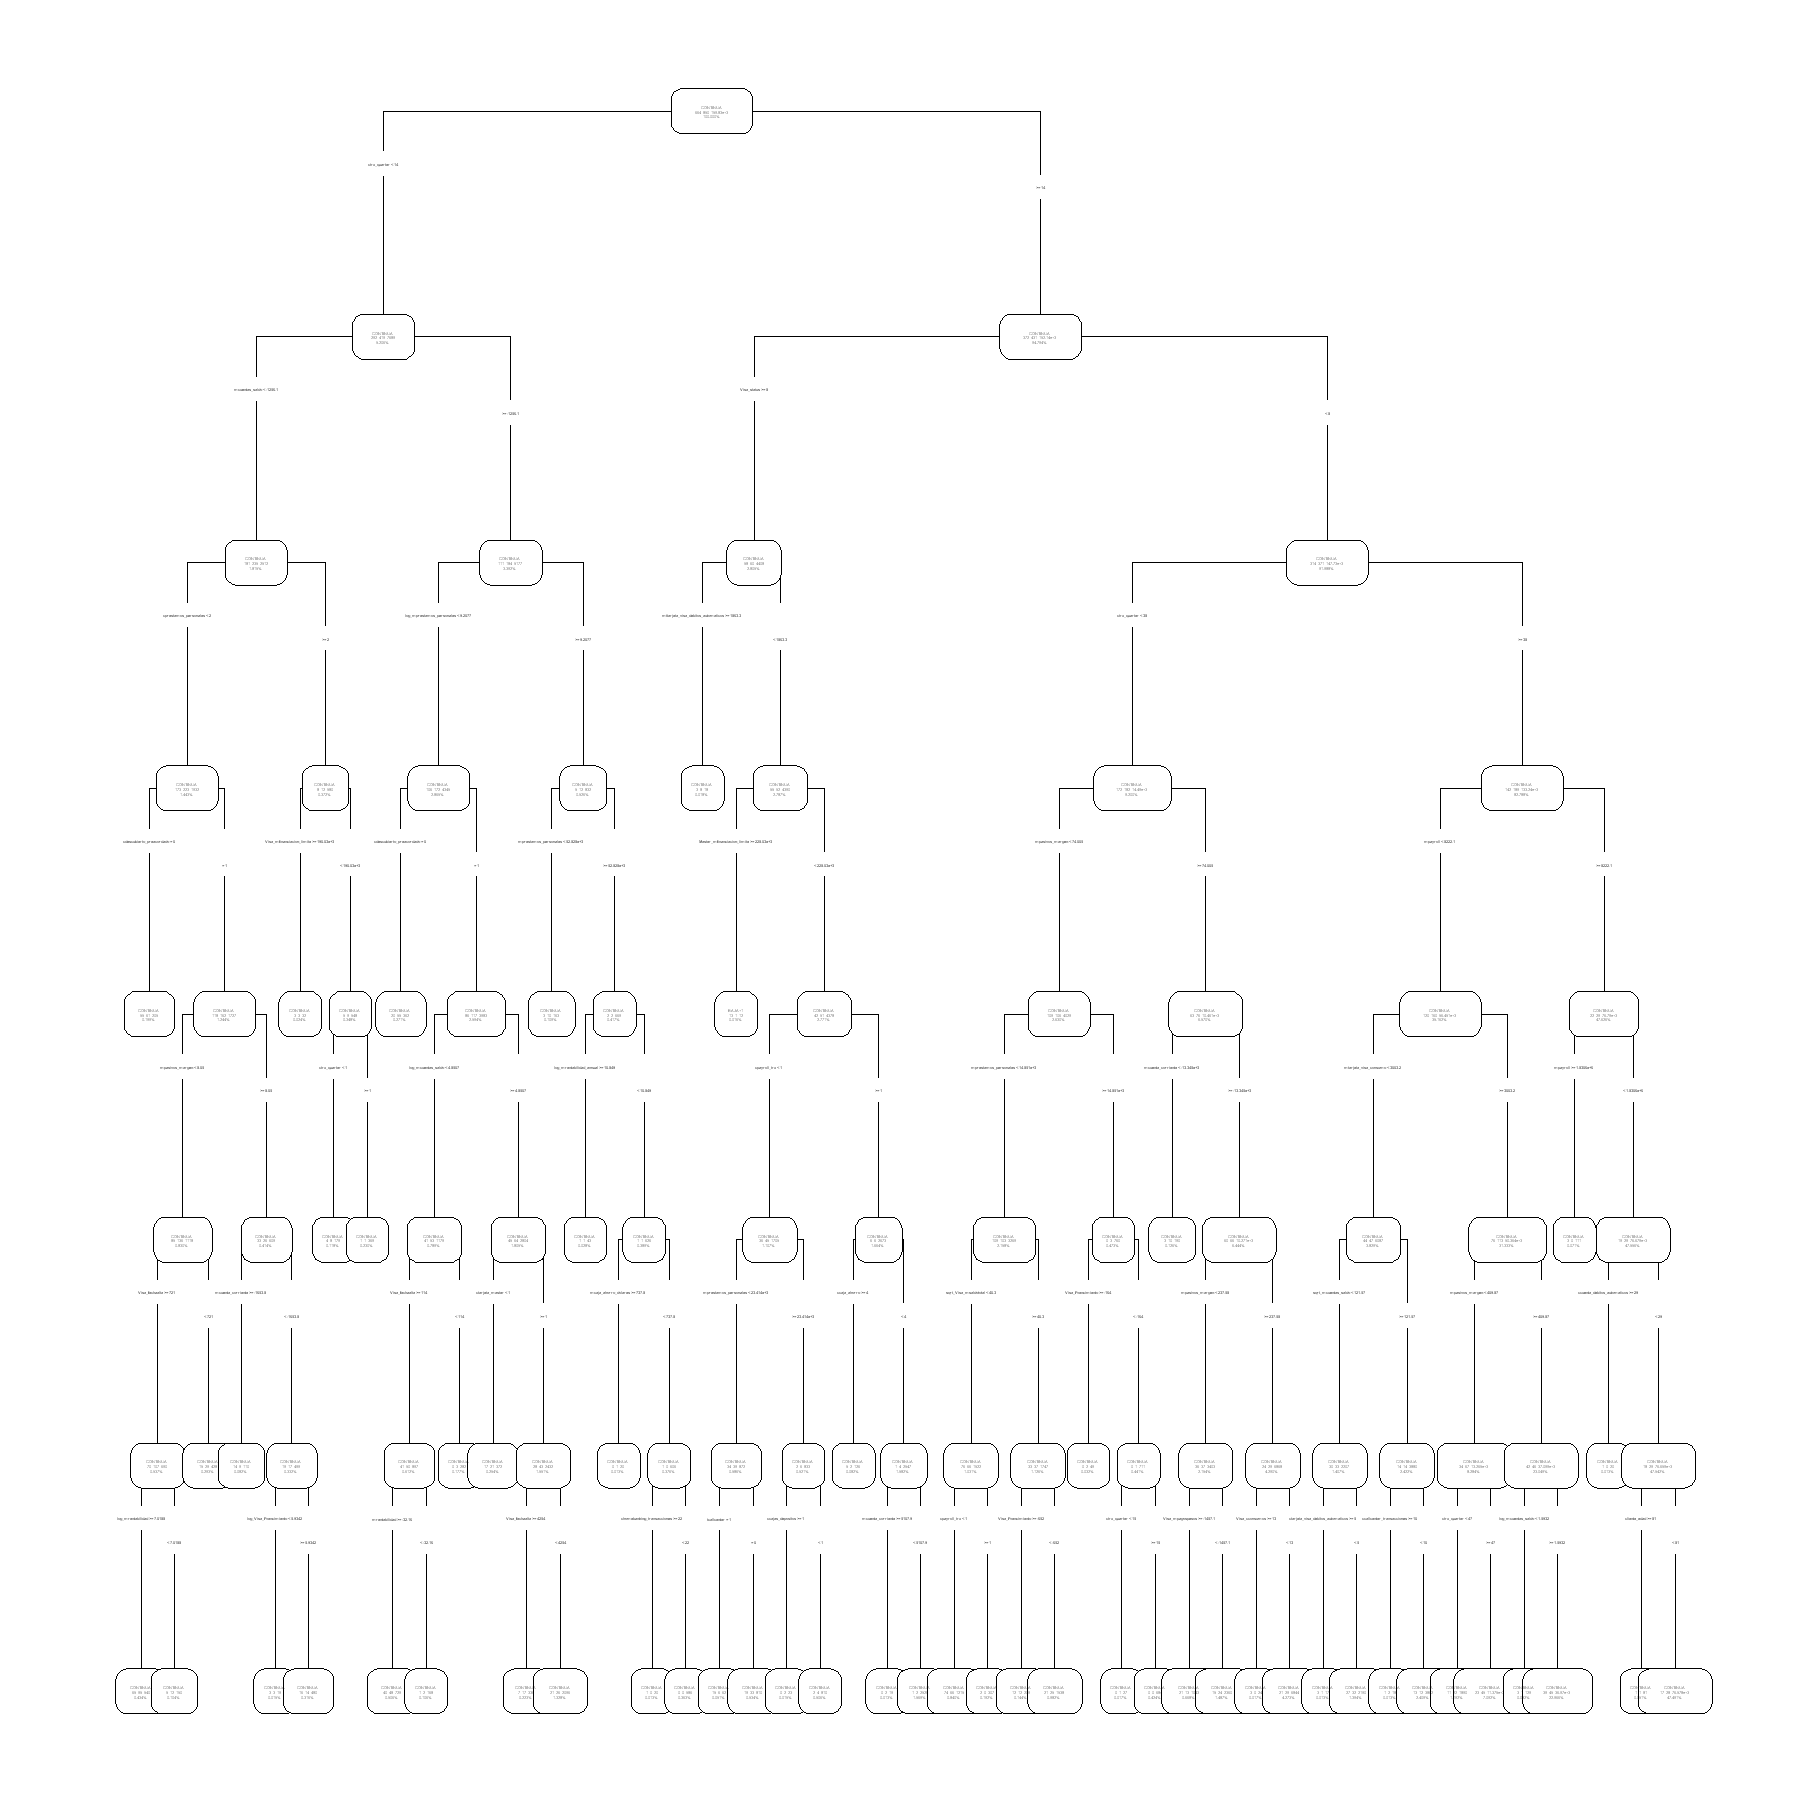

In [219]:
#Arbol generado
options(repr.plot.width=15, repr.plot.height=15)
prp(modelo, extra=101, digits=5, branch=1, type=4, varlen=0, faclen=0, tweak=1.3)

In [220]:
names(modelo$variable.importance)

[1] "ctrx_quarter"                        
 [2] "cdescubierto_preacordado"            
 [3] "mcuentas_saldo"                      
 [4] "mprestamos_personales"               
 [5] "sqrt_mprestamos_personales"          
 [6] "active_quarter"                      
 [7] "mcuenta_corriente"                   
 [8] "cprestamos_personales"               
 [9] "Visa_status"                         
[10] "ccomisiones_otras"                   
[11] "mv_status01"                         
[12] "mpasivos_margen"                     
[13] "mactivos_margen"                     
[14] "mcomisiones_mantenimiento"           
[15] "mcaja_ahorro"                        
[16] "mcomisiones"                         
[17] "sqrt_mrentabilidad"                  
[18] "ctarjeta_visa"                       
[19] "Visa_fechaalta"                      
[20] "mpayroll"                            
[21] "cpayroll_trx"                        
[22] "log_Visa_Fvencimiento"               
[23] "sqrt_Visa_Fvencimiento"              
[24] "Visa_Fvencimiento"                   
[25] "mttarjeta_visa_debitos_automaticos"  
[26] "log_mprestamos_personales"           
[27] "cliente_antiguedad"                  
[28] "sqrt_mcuentas_saldo"                 
[29] "log_mcuentas_saldo"                  
[30] "sqrt_mrentabilidad_annual"           
[31] "ccallcenter_transacciones"           
[32] "mtarjeta_visa_consumo"               
[33] "mrentabilidad"                       
[34] "log_Master_mlimitecompra"            
[35] "Master_mfinanciacion_limite"         
[36] "Master_mlimitecompra"                
[37] "sqrt_Master_mlimitecompra"           
[38] "cproductos"                          
[39] "Visa_mfinanciacion_limite"           
[40] "Visa_mlimitecompra"                  
[41] "ctarjeta_visa_debitos_automaticos"   
[42] "tcallcenter"                         
[43] "mcomisiones_otras"                   
[44] "Master_fechaalta"                    
[45] "log_mrentabilidad"                   
[46] "ctarjeta_visa_transacciones"         
[47] "sqrt_Visa_msaldototal"               
[48] "Visa_msaldopesos"                    
[49] "Visa_msaldototal"                    
[50] "tcuentas"                            
[51] "Visa_mpagominimo"                    
[52] "mrentabilidad_annual"                
[53] "ctarjeta_master"                     
[54] "ccomisiones_mantenimiento"           
[55] "log_mrentabilidad_annual"            
[56] "log_Visa_mfinanciacion_limite"       
[57] "log_Visa_mlimitecompra"              
[58] "sqrt_Visa_mfinanciacion_limite"      
[59] "sqrt_Visa_mlimitecompra"             
[60] "mextraccion_autoservicio"            
[61] "Visa_cconsumos"                      
[62] "cextraccion_autoservicio"            
[63] "ccaja_ahorro"                        
[64] "log_Visa_msaldototal"                
[65] "matm"                                
[66] "sqrt_matm"                           
[67] "Visa_mpagospesos"                    
[68] "ccajas_depositos"                    
[69] "mttarjeta_master_debitos_automaticos"
[70] "ctarjeta_master_debitos_automaticos" 
[71] "numero_de_cliente"                   
[72] "internet"                            
[73] "ccuenta_debitos_automaticos"         
[74] "chomebanking_transacciones"          
[75] "mcaja_ahorro_dolares"                
[76] "cliente_edad"                        
[77] "ctarjeta_debito_transacciones"       
[78] "Master_status"                       
[79] "ccheques_depositados"                
[80] "mcheques_depositados"                
[81] "cinversion2"                         
[82] "minversion2"                         
[83] "mautoservicio"                       
[84] "mcaja_ahorro_adicional"              
[85] "ctransferencias_recibidas"           
[86] "matm_other"                          
[87] "mtransferencias_emitidas"            
[88] "sqrt_matm_other"